## Initial Setup

In [31]:
import os
datapath = os.path.join("dataset", "home-credit-default-risk")

# Import and settings for plotings figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# Import panda
import pandas as pd
pd.set_option('display.max_columns', 500)

# Create a function to load the dataset into a panda object
def load_dataset(filename, path=datapath):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

# Import numpy
import numpy as np

## Load Dataset

In [32]:
app_train = load_dataset("application_train.csv")
app_test = load_dataset("application_test.csv")
print("app_test shape: ", app_train.shape)
print("app_test shape: ", app_test.shape)

app_test shape:  (307511, 122)
app_test shape:  (48744, 121)


## Data Pre Processing

### Fixing anomalies

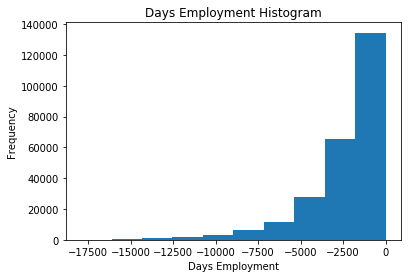

In [33]:
import numpy as np

app_train['DAYS_EMPLOYED_ANOM'] = (app_train["DAYS_EMPLOYED"] == 365243)


app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [34]:
app_test['DAYS_EMPLOYED_ANOM'] = (app_test['DAYS_EMPLOYED'] == 365243)
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

### Encoding

**Label encoding**

In [35]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            labelEncoder.fit(app_train[col])

            app_train[col] = labelEncoder.transform(app_train[col])
            app_test[col] = labelEncoder.transform(app_test[col])
            
            count += 1
            
print('%d columns were label encoded.' % count)

3 columns were label encoded.


**one-hot encoding**

In [36]:
print('before training shape: ', app_train.shape)
print('before test shape: ', app_test.shape)

# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('after training shape: ', app_train.shape)
print('after test shape: ', app_test.shape)


before training shape:  (307511, 123)
before test shape:  (48744, 122)
after training shape:  (307511, 244)
after test shape:  (48744, 240)


In [37]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dfs
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 240)


In [38]:
# Save training target labels and ids
train_labels = app_train['TARGET']
train_ids = app_train['SK_ID_CURR']
test_ids = app_test['SK_ID_CURR']
app_train = app_train.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
app_test = app_test.drop(['SK_ID_CURR'], axis = 1)

## Feature Selection

### Remove collinear features

In [39]:
# Threshold for removing correlated variables
threshold = 0.95

# Absolute value correlation matrix
corr_matrix = app_train.corr().abs()
corr_matrix.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORG

In [40]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), 
                                  k=1).astype(np.bool))
upper.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORG

In [41]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 35 columns to remove.


In [42]:
print('Training shape before: ', app_train.shape)
print('Test shape before: ', app_test.shape)
app_train = app_train.drop(columns = to_drop)
app_test = app_test.drop(columns = to_drop)
print('Training shape after: ', app_train.shape)
print('Test shape after: ', app_test.shape)

Training shape before:  (307511, 239)
Test shape before:  (48744, 239)
Training shape after:  (307511, 204)
Test shape after:  (48744, 204)


### Remove features with zero importance

In [43]:
feature_importances = pd.read_csv('./feature_importances_rf.csv')

In [44]:
feature_importances.head()

,Unnamed: 0,feature,importance
0,0,EXT_SOURCE_3,0.173453
1,1,EXT_SOURCE_2,0.166004
2,2,EXT_SOURCE_1,0.057938
3,3,DAYS_EMPLOYED,0.044781
4,4,DAYS_BIRTH,0.035080


In [45]:
feature_importances = feature_importances[~feature_importances[
                        'feature'].isin(to_drop)]

In [46]:
zero_features = list(feature_importances[feature_importances[
    'importance'] == 0]['feature'])

In [47]:
zero_features

['FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_10',
 'FLAG_MOBIL',
 'NAME_INCOME_TYPE_Businessman',
 'NAME_INCOME_TYPE_Student']

In [48]:
print('Training shape before: ', app_train.shape)
print('Test shape before: ', app_test.shape)
app_train = app_train.drop(zero_features, axis=1)
app_test = app_test.drop(zero_features, axis=1)
print('Training shape after: ', app_train.shape)
print('Test shape after: ', app_train.shape)

Training shape before:  (307511, 204)
Test shape before:  (48744, 204)
Training shape after:  (307511, 198)
Test shape after:  (307511, 198)


### Keep only the most relevant features

In [49]:
# Cumulative importance selected
cum_importance = 0.95

In [50]:
feature_importances['importance_normalized'] = feature_importances[
    'importance'] / feature_importances['importance'].sum()

In [51]:
feature_importances['cumulative_importance'] = np.cumsum(feature_importances[
    'importance_normalized'])

In [52]:
feature_importances.head(4)

,Unnamed: 0,feature,importance,importance_normalized,cumulative_importance
0,0,EXT_SOURCE_3,0.173453,0.205726,0.205726
1,1,EXT_SOURCE_2,0.166004,0.196891,0.402617
2,2,EXT_SOURCE_1,0.057938,0.068718,0.471335
3,3,DAYS_EMPLOYED,0.044781,0.053113,0.524449


In [53]:
features_to_keep = list(feature_importances[feature_importances[
                    'cumulative_importance'] 
                    < cum_importance]['feature'])
print('\nThere are %d features that will be kept' % len(features_to_keep))


There are 62 features that will be kept


In [54]:
app_train = app_train[features_to_keep]
app_test = app_test[features_to_keep]

In [55]:
print('Training shape after: ', app_train.shape)
print('Test shape after: ', app_train.shape)

Training shape after:  (307511, 62)
Test shape after:  (307511, 62)


### Missing values and Features Scaling

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
])

In [57]:
train = pipeline.fit_transform(app_train)
test = pipeline.fit_transform(app_test)
print('Training Features shape: ', train.shape)
print('Test Features shape: ', test.shape)

Training Features shape:  (307511, 62)
Test Features shape:  (48744, 62)


## Modeling - Base Scenario

## Logistic Regression (Cross Validated)

In [58]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="liblinear", random_state=10)

In [59]:
from sklearn.model_selection import cross_val_predict

labels_prob_lr = cross_val_predict(log_reg, train, train_labels, cv=6, 
                                method="predict_proba")

**ROC Curve**

In [60]:
from sklearn.metrics import roc_curve

In [61]:
from sklearn.metrics import roc_curve
# TPR: True Positive Rate
# FPR: False Positive Rate
fpr_lr, tpr_lr, thresholds_lr = roc_curve(train_labels, labels_prob_lr[:,1])

In [62]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

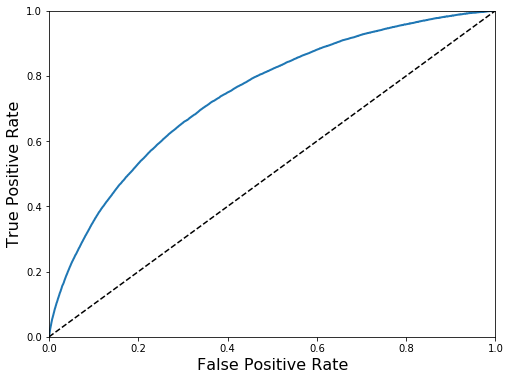

In [63]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_lr, tpr_lr)
plt.show()

**Calculate AUC**

In [64]:
from sklearn.metrics import roc_auc_score
roc_auc_score(train_labels, labels_prob_lr[:,1])

0.741229503776387

**Save metrics**

In [65]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_lr = np.c_[fpr_lr, tpr_lr, thresholds_lr]
metrics_lr = pd.DataFrame(metrics_lr, columns=metrics_names)
metrics_lr.to_csv('metrics_lr_fs.csv')

label_names = list(['orig', 'prob'])
labels_lr = np.c_[train_labels, labels_prob_lr[:,1]]
labels_lr = pd.DataFrame(labels_lr, columns=label_names)
labels_lr.to_csv('labels_lr_fs.csv')

## Random Forest (Cross Validated)

In [66]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=256, 
                                n_jobs=-1, random_state=10)

In [67]:
from sklearn.model_selection import cross_val_predict

labels_prob_rf = cross_val_predict(rf_clf, train, train_labels, cv=6, 
                                   method="predict_proba")

**ROC Curve**

In [68]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(train_labels, labels_prob_rf[:,1])

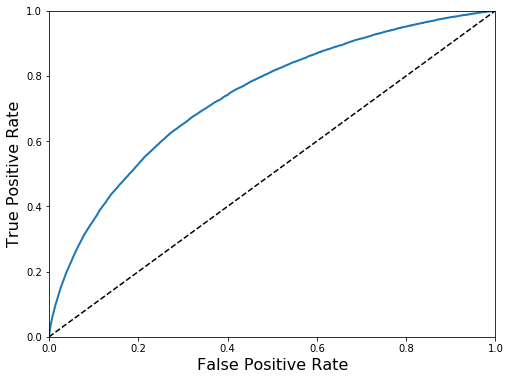

In [69]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_rf, tpr_rf)
plt.show()

**Calculate AUC**

In [70]:
roc_auc_score(train_labels, labels_prob_rf[:,1])

0.7369439451281901

**Save metrics**

In [71]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_rf = np.c_[fpr_rf, tpr_rf, thresholds_rf]
metrics_rf = pd.DataFrame(metrics_rf, columns=metrics_names)
metrics_rf.to_csv('metrics_rf_fs.csv')

label_names = list(['orig', 'prob'])
labels_rf = np.c_[train_labels, labels_prob_rf[:,1]]
labels_rf = pd.DataFrame(labels_rf, columns=label_names)
labels_rf.to_csv('labels_rf_fs.csv')

## Linear SVM

In [72]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svm_clf = LinearSVC(C=1, loss="hinge", random_state=10, max_iter=5000)
cc_svm = CalibratedClassifierCV(base_estimator=svm_clf, method='sigmoid')

In [73]:
cc_svm.fit(train, train_labels)

C:\jcabelloc\Programs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\jcabelloc\Programs\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\jcabelloc\Programs\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CalibratedClassifierCV(base_estimator=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=5000, multi_class='ovr',
     penalty='l2', random_state=10, tol=0.0001, verbose=0),
            cv='warn', method='sigmoid')

In [74]:
labels_prob_lsvm = cc_svm.predict_proba(train)

**ROC Curve**

In [79]:
fpr_lsvm, tpr_lsvm, thresholds_lsvm = roc_curve(
                    train_labels, labels_prob_lsvm[:,1])

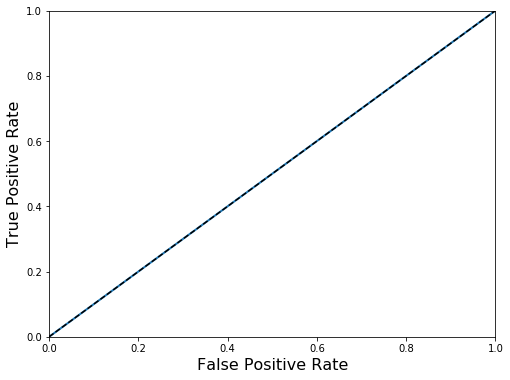

In [80]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_lsvm, tpr_lsvm)
plt.show()

**Calculate AUC**

In [81]:
roc_auc_score(train_labels, labels_prob_lsvm[:,1])

0.5001093709752323

**Save metrics**

In [82]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_lsvm = np.c_[fpr_lsvm, tpr_lsvm, thresholds_lsvm]
metrics_lsvm = pd.DataFrame(metrics_lsvm, columns=metrics_names)
metrics_lsvm.to_csv('metrics_lsvm_fs.csv')

label_names = list(['orig', 'prob'])
labels_lsvm = np.c_[train_labels, labels_prob_lsvm[:,1]]
labels_lsvm = pd.DataFrame(labels_lsvm, columns=label_names)
labels_lsvm.to_csv('labels_lsvm_fs.csv')

## Adaboost

In [83]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=250,
    algorithm="SAMME.R", learning_rate=0.5, random_state=10)

In [84]:
from sklearn.model_selection import cross_val_predict

labels_prob_ada = cross_val_predict(ada_clf, train, train_labels, cv=6, 
                                   method="predict_proba")

**ROC Curve**

In [85]:
fpr_ada, tpr_ada, thresholds_ada = roc_curve(
                    train_labels, labels_prob_ada[:,1])

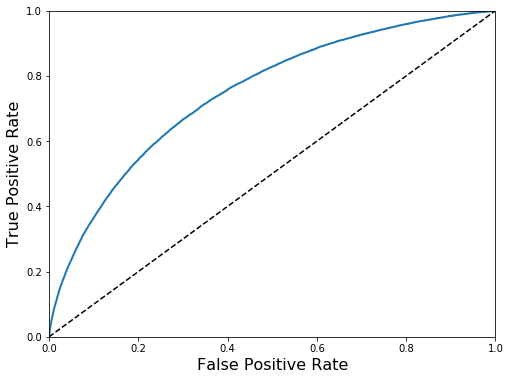

In [86]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_ada, tpr_ada)
plt.show()

**Calculate AUC**

In [87]:
roc_auc_score(train_labels, labels_prob_ada[:,1])

0.7472036080813289

**Save metrics**

In [88]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_ada = np.c_[fpr_ada, tpr_ada, thresholds_ada]
metrics_ada = pd.DataFrame(metrics_ada, columns=metrics_names)
metrics_ada.to_csv('metrics_ada_fs.csv')

label_names = list(['orig', 'prob'])
labels_ada = np.c_[train_labels, labels_prob_ada[:,1]]
labels_ada = pd.DataFrame(labels_ada, columns=label_names)
labels_ada.to_csv('labels_ada_fs.csv')

## Neural Network

**Split the training dataset into training and validation dataset**

In [89]:
X_valid, X_train = train[:50000], train[50000:]
y_valid, y_train = train_labels[:50000].values, train_labels[50000:].values

In [90]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [91]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

**Define network architecture parameters**

In [92]:
train_labels.shape

(307511,)

In [93]:
X_train.shape[1]

62

In [94]:
import tensorflow as tf

def reset_graph(seed=10):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

n_inputs = X_train.shape[1]  # number of features
n_hidden1 = 64
n_hidden2 = 64
n_hidden3 = 64
n_outputs = 2

In [95]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

**Buil the network with regularization**

In [96]:
scale = 0.001

In [97]:
from functools import partial
my_dense_layer = partial(
    tf.layers.dense, activation=leaky_relu,
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    hidden3 = my_dense_layer(hidden2, n_hidden3, name="hidden3")
    logits = my_dense_layer(hidden3, n_outputs, activation=None,
                            name="outputs")
    y_proba = tf.nn.softmax(logits)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [98]:
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  
        labels=y, logits=logits)                                
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

**Select the AdamOptimizer**

In [99]:
learning_rate = 0.001

with tf.name_scope("train"):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
                                      
    training_op = optimizer.minimize(loss)

In [100]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [101]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

**Train the network**

In [102]:
n_epochs = 10
batch_size = 512

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, 
              "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./nn_base_fs_model.ckpt")

0 Batch accuracy: 0.88671875 Validation accuracy: 0.91948
1 Batch accuracy: 0.92578125 Validation accuracy: 0.91948
2 Batch accuracy: 0.9277344 Validation accuracy: 0.91948
3 Batch accuracy: 0.9003906 Validation accuracy: 0.91948
4 Batch accuracy: 0.9160156 Validation accuracy: 0.91948
5 Batch accuracy: 0.9121094 Validation accuracy: 0.91948
6 Batch accuracy: 0.94140625 Validation accuracy: 0.91948
7 Batch accuracy: 0.92578125 Validation accuracy: 0.91948
8 Batch accuracy: 0.9238281 Validation accuracy: 0.91948
9 Batch accuracy: 0.9199219 Validation accuracy: 0.91948


In [103]:
with tf.Session() as sess:
    saver.restore(sess, "./nn_base_fs_model.ckpt") 
    labels_prob_nn = y_proba.eval(feed_dict={X: X_valid})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./nn_base_fs_model.ckpt


**ROC curve**

In [104]:
fpr_nn, tpr_nn, thresholds_nn = roc_curve(
                    y_valid, labels_prob_nn[:,1])

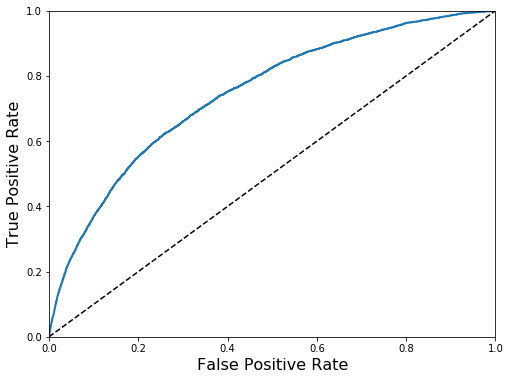

In [105]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_nn, tpr_nn)
plt.show()

**Calculate AUC**

In [106]:
roc_auc_score(y_valid, labels_prob_nn[:,1])

0.7465968826285991

**Save Metrics**

In [107]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_nn = np.c_[fpr_nn, tpr_nn, thresholds_nn]
metrics_nn = pd.DataFrame(metrics_nn, columns=metrics_names)
metrics_nn.to_csv('metrics_nn_fs.csv')

label_names = list(['orig', 'prob'])
labels_nn = np.c_[y_valid, labels_prob_nn[:,1]]
labels_nn = pd.DataFrame(labels_nn, columns=label_names)
labels_nn.to_csv('labels_nn_fs.csv')